In [1]:
# For embedding audio player
import IPython

# Plots
import matplotlib.pyplot as plt
from pylab import plot, show, figure, imshow
plt.rcParams['figure.figsize'] = (15, 6)
import numpy as np
import essentia.standard as es
import essentia

[   INFO   ] MusicExtractorSVM: no classifier models were configured by default


In [2]:
audio_file = '../audio_files/clip-MJ_Maraka_1_J1.wav'
IPython.display.Audio(audio_file)

In [7]:
# STEP 1: novelty function - what's the best one?

# Load audio file.
audio = es.MonoLoader(filename=audio_file, sampleRate=8000)()

# 1. Compute the onset detection function (ODF).
n_mels = 40
window_size = 256
hop_size = 160
pool = essentia.Pool()
# TODO: use SuperFluxNovelty
# windowing = es.Windowing(type='hann')
# spectrum = es.Spectrum()
# melbands = es.MelBands()
# spf = es.SuperFluxNovelty()

# for frame in es.FrameGenerator(audio, frameSize=window_size, hopSize=hop_size):
#     foo = melbands(spectrum(windowing(frame)))
#     pool.add('melbands', foo)
#     pool.add("spf", spf(pool["melbands"]))


# fig, ax = plt.subplots()
# ax.plot(pool['spf'])

#----------------------------------------------

# The OnsetDetection algorithm provides various ODFs.
od_mel = es.OnsetDetection(method='melflux')
w = es.Windowing(type='hann')
fft = es.FFT() # Outputs a complex FFT vector.
c2p = es.CartesianToPolar() # Converts it into a pair of magnitude and phase vectors.

# Compute both ODF frame by frame. Store results to a Pool.
pool = essentia.Pool()
for frame in es.FrameGenerator(audio, frameSize=256, hopSize=160):
    magnitude, phase = c2p(fft(w(frame)))
    pool.add('odf.mel', od_mel(magnitude, phase))

fig, ax = plt.subplots()
ax.plot(pool['odf.mel'])

[   INFO   ] TriangularBands: input spectrum size (129) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.


RuntimeError: In OnsetDetection.compute: TriangularBands: the number of spectrum bins is insufficient for the specified number of triangular bands. Use zero padding to increase the number of FFT bins.

In [4]:
fs = 8000 / 512

auto_w = int(np.ceil(fs * 8))
auto_h = int(np.ceil(fs * 0.5))
print(auto_w, auto_h)
auto = es.AutoCorrelation()

for frame in es.FrameGenerator(pool["odf.mel"], frameSize=auto_w, hopSize=auto_h):
    pool.add("local_autocorr", auto(frame))

125 8


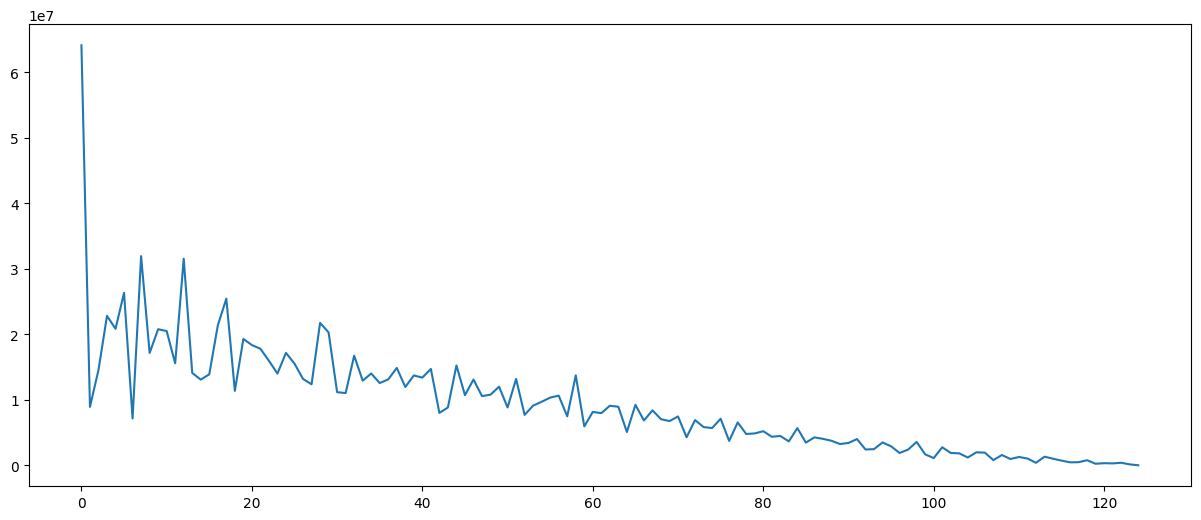

In [5]:
fig, ax = plt.subplots()
foo = pool["local_autocorr"]
ax.plot(np.mean(foo.T, axis=1))

In [6]:
# audio = es.MonoLoader(filename=audio_file, sampleRate=8000)()
# windowing = es.Windowing(type='hann', zeroPadding=256)
# spectrum = es.Spectrum()
# melbands = es.MelBands(inputSize=window_size+1, numberBands=40, lowFrequencyBound=0, highFrequencyBound=11000)
# spectrum_logfreq = es.LogSpectrum(binsPerSemitone=1)

# amp2db = es.UnaryOperator(type='lin2db', scale=2)
# pool = essentia.Pool()

# for frame in es.FrameGenerator(audio, frameSize=window_size, hopSize=hop_size):
#     frame_spectrum = spectrum(windowing(frame))
#     frame_mel = melbands(frame_spectrum)
#     # pool.add('mel96_db', frame_spectrum)

#     pool.add('mel96_db', amp2db(frame_mel))


# foo = pool['mel96_db']
# print(foo.shape[0])
# spf = es.SuperFluxNovelty(frameWidth=foo.shape[0])
# fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# ax.set_title("Mel log-spectrogram (amp2db)")
# ax.set_xlabel("Time (frames)")
# ax.set_ylabel("Mel frequency bands")
# ax.imshow(pool['mel96_db'].T, aspect = 'auto', origin='lower', interpolation='none')

# show()
# l = []
# for idx, _ in enumerate(foo[:100]):
#     bar = np.array(foo[idx], foo[idx+1])
#     l.append(spf(bar))

# foo = spf.compute(pool['mel96_db'])

# foo